# Preprocessing

Import libraries and functions, mount google drive and read in data

In [ ]:
import pandas as pd
!pip install tweet-preprocessor
!pip3 show tensorflow
#!pip install tensorflow-gpu==1.15.2
import preprocessor as p
import numpy as np
from tqdm.notebook import tqdm_notebook, tqdm
import requests
from io import StringIO
from google.colab import drive
import string

from nltk import ngrams

import sys
import csv
maxInt = sys.maxsize

while True:

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

drive.mount('/content/drive')
test_path = '/content/drive/My Drive/UK/development/UK_bal_test_indiv.csv'
#exp_path ='/content/drive/My Drive/Germany/experiment/indiv_exp.csv'
train = pd.read_csv('/content/drive/My Drive/UK/development/train_indiv.csv', index_col=0, engine='python', error_bad_lines=False)
train = train.sample(frac=1)
train_label = train['Label'].copy().values
train_sents = train['CTweet'].copy().values
w = train.Label.value_counts(normalize=True)
weights ={0:1/w[0], 1:1/w[1]}
print(weights)
#weights={0:1, 1:14}
print(weights)
train

import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) # english, spanish, french, italian, german


Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: wheel, h5py, numpy, tensorboard, absl-py, tensorflow-estimator, opt-einsum, keras-preprocessing, termcolor, wrapt, grpcio, gast, protobuf, astunparse, six, scipy, google-pasta
Required-by: fancyimpute
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{0: 1.0871637139632675, 1: 12.47266396222421}
{0: 1.0871637139632675, 1: 12.47266396222421}
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define final cleaning and sparisty reduction

In [ ]:
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG)

def clean(tweets, min_occurence):
   #########
  vocab_freq = {'<PAD>':min_occurance,'<UNK>':min_occurance}

  for tweet in tqdm(tweets):
    tokenized = tweet.split(' ')
    for word in tokenized:
      if word not in vocab_freq.keys():
        vocab_freq[word] = 1
      else:
        vocab_freq[word]+=1

  recons_sent = []
  for tweet in tqdm(tweets):
    tokenized = tweet.split(' ')
    new_sent = []
    for word in tokenized:
      if word not in vocab_freq.keys() or vocab_freq[word] <min_occurance or word in stop_words or word.isdigit():
        new_sent.append('<UNK>')
      else:
        new_sent.append(word)
    recons_sent.append(new_sent)
  return recons_sent, vocab_freq

min_occurance =10
recons_sent, vocab_freq = clean(train_sents, min_occurence=min_occurance)

RAM boosting for google colab (increases RAM from 16GB to 25GB), vocabulary definition and sentence numerizing

In [ ]:
def boost_ram():
  a = []
  while(1):
    a.append('1')

#boost_ram()

final_vocab =[key for key, val in vocab_freq.items() if val >=min_occurance]
ids_to_word = {ind:word for ind, word in enumerate(final_vocab)}
word_to_ids = {word:ind for ind, word in enumerate(final_vocab)}

numerized_sent = np.array([np.array([word_to_ids[word] for word in tweet]) for tweet in recons_sent]) #.transpose inside
print(len(final_vocab))

maxlen=len(max(numerized_sent, key=len))
for ind, row in enumerate(numerized_sent):
  if len(row)==maxlen:
    final = ind

print('maxlen', maxlen)
#train.iloc[final]


64547
maxlen 131


# 

In [ ]:
####uncomment numerized test
###from keras.utils import to_categorical
def labels(labs, t = None):
  lab = []
  pos=0
  if t == 'time':
    for l in labs:
      l = list(l)
      if 'D' in l:
        pos+=1
        lab.append(1)
      else:
        lab.append(0)
    print(pos/len(lab))
    return (np.array(lab)).astype(int)

  else:
    if 'Depressed' in labs:
      print('inside')
    #return pd.get_dummies(df.Label).reset_index(drop=True)
    
    for i in labs:
      if i =='Depressed':
        lab.append(1)
      else:
        lab.append(0)
    return (np.array(lab)).astype(int)

print(set(train_label))
train_labels = labels(train_label, t ='time')
#print(np.shape(train_labels))
#print(set(train_labels))
print(np.unique(train_labels))

def custom_round(i):
  if i >=0.5:
    return 1
  else:
    return 0
#print(set([custom_round(p) for p in model.predict(X_train)]))


test = pd.read_csv(test_path, index_col=0, encoding='utf8', engine='python', error_bad_lines=False)
test_label = test['Label'].copy().values
test_sent = test['CTweet'].copy().values
print(type(test_label), len(test_label), set(test_label))
test_labels =labels(test_label, t='time')
print(np.unique(test_labels))

num_list, num_freq = np.unique(test_labels)
print('*', num_freq)

recons_sent_test=[]
for tweet in test_sent:
  tokenized = tweet.split(' ')
  new_sent = []
  for word in tokenized:
    if word not in vocab_freq.keys() or vocab_freq[word] <min_occurance or word in stop_words or word.isdigit():
      new_sent.append('<UNK>')
    else:
      new_sent.append(word)
  recons_sent_test.append(new_sent)
numerized_test =np.array([np.array([word_to_ids[word] for word in tweet]) for tweet in recons_sent_test]) ### comment this for bert to save ram
'''

exp = pd.read_csv(exp_path, index_col=0, encoding='utf8', engine='python', error_bad_lines=False)
exp_sent = exp['CTweet'].copy().values
print(exp)
print(exp.columns)
recons_sent_exp=[]
for tweet in exp_sent:
  tokenized = tweet.split(' ')  
  new_sent = []
  for word in tokenized:
    if word not in vocab_freq.keys() or vocab_freq[word] <min_occurance or word in stop_words or word.isdigit():
      new_sent.append('<UNK>')
    else:
      new_sent.append(word)
  recons_sent_exp.append(new_sent)
numerized_exp =np.array([np.array([word_to_ids[word] for word in tweet]) for tweet in recons_sent_exp])'''


{'None', 'Depressed'}
0.08017533407688097
[0 1]
<class 'numpy.ndarray'> 115850 {'None', 'Depressed'}
0.4987570133793699
[0 1]
* 1


"\n\nexp = pd.read_csv(exp_path, index_col=0, encoding='utf8', engine='python', error_bad_lines=False)\nexp_sent = exp['CTweet'].copy().values\nprint(exp)\nprint(exp.columns)\nrecons_sent_exp=[]\nfor tweet in exp_sent:\n  tokenized = tweet.split(' ')  \n  new_sent = []\n  for word in tokenized:\n    if word not in vocab_freq.keys() or vocab_freq[word] <min_occurance or word in stop_words or word.isdigit():\n      new_sent.append('<UNK>')\n    else:\n      new_sent.append(word)\n  recons_sent_exp.append(new_sent)\nnumerized_exp =np.array([np.array([word_to_ids[word] for word in tweet]) for tweet in recons_sent_exp])"

# Models

Padding samples

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import keras
ohe = OneHotEncoder(handle_unknown='ignore')
#ohe_labels = ohe.fit_transform(train_labels)
MAXLENGTH=120
#120 indiv
#X_exp = keras.preprocessing.sequence.pad_sequences(numerized_exp, maxlen=MAXLENGTH, padding='post', value=0)
X_test = keras.preprocessing.sequence.pad_sequences(numerized_test, maxlen=MAXLENGTH, padding='post', value=0)
X_train = keras.preprocessing.sequence.pad_sequences(numerized_sent, maxlen=MAXLENGTH, padding='post', value=0)#, keras.preprocessing.sequence.pad_sequences(numerized_test, maxlen=MAXLENGTH, padding='post', value=0)
#print('done padding')
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13721116482753433012, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17931792607867235859
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18180536153470192801
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15695549568
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8766724516183252397
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

## Variety of fully Connected-based Models

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv2D,Conv1D, Dropout, Reshape, BatchNormalization, MaxPool2D, TimeDistributed, Flatten, Input, Concatenate, Bidirectional, GRU, LSTM
from tensorflow.keras.models import Sequential, Model
import keras


embedding_size=100
vocab_size=len(final_vocab)+1
cnt=0
len_array =[]
for ind, row in enumerate(numerized_sent):
  len_array.append(len(list(row)))
  if int(len(list(row)))>cnt:
    cnt=len(row)
    i=ind

print(len(recons_sent[i]))


def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove
  
from keras.initializers import Constant
def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = keras.layers.Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable)
    return embeddingLayer

class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


def glove_model():
  #!wget http://nlp.stanford.edu/data/glove.6B.zip
  import zipfile
  import os
  path = 'glove.6B.zip'
  directory = os.getcwd()
  zipfile_ = zipfile.ZipFile(path, 'r')
  zipfile_.extractall(directory)
  zipfile_.close()
  wordToIndex, indexToWord, wordToGlove = readGloveFile('glove.6B.300d.txt')
  model_glove = keras.Sequential()
  model_glove.add(createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable=True))
  #model_glove.add(GlobalAveragePooling1DMasked())
  model_glove.add(Bidirectional(LSTM(embedding_size)))
  #model_glove.add(keras.layers.Dense(256, activation='relu'))###
  #model_glove.add(keras.layers.Dense(128, activation='relu'))###
  #model_glove.add(keras.layers.Dense(64, activation='relu'))###
  #model_glove.add(keras.layers.Dense(16, activation='relu'))
  model_glove.add(Dense(50, activation='relu'))
  model_glove.add(Dense(30, activation='relu'))
  model_glove.add(Dense(10, activation='relu'))
  model_glove.add(Dense(1, activation='sigmoid'))
  model_glove.summary()
  model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
  return model_glove




def trip_cnn_bi_aux_model():
  inp = Input(shape=(MAXLENGTH, ), dtype='int32')
  embedding = Embedding(vocab_size, embedding_size)(inp)
  reshape = Reshape((MAXLENGTH, embedding_size,1))(embedding)
  con1 = Conv2D(1, kernel_size=(1,embedding_size), strides=1, padding='valid')(reshape)
  bn1 = BatchNormalization()(con1)
  mxpl1 = MaxPool2D(pool_size=(MAXLENGTH-3+1, 1), padding='valid')(bn1)

  con2 = Conv2D(1, kernel_size=(2,embedding_size), strides=1, padding='valid')(reshape)
  bn2 = BatchNormalization()(con2)
  mxpl2 = MaxPool2D(pool_size=(MAXLENGTH-3+1, 1), padding='valid')(bn2)

  con3 = Conv2D(1, kernel_size=(3,embedding_size), strides=1, padding='valid')(reshape)
  bn3 = BatchNormalization()(con3)
  mxpl3 = MaxPool2D(pool_size=(MAXLENGTH-3+1, 1), padding='valid')(bn3)

  #con4 = Conv2D(1, kernel_size=(4,embedding_size), strides=1, padding='valid')(reshape)
  #bn4 = BatchNormalization()(con4)
  #mxpl4 = MaxPool2D(pool_size=(MAXLENGTH-3+1, 1), padding='valid')(bn4)

  #con5 = Conv2D(1, kernel_size=(5,embedding_size), strides=1, padding='valid')(reshape)
  #bn5 = BatchNormalization()(con5)
  #mxpl5 = MaxPool2D(pool_size=(MAXLENGTH-3+1, 1), padding='valid')(bn5)

  conc = Concatenate()([mxpl1, mxpl2, mxpl3])#, mxpl4])#, mxpl5])
  flat=TimeDistributed(Flatten())(conc)

  #aux_dns1 = Dense(100, activation='relu')(flat)
  #aux_drop1 = Dropout(0.5)(aux_dns1)
  #aux_out1 = Dense(1, activation='sigmoid', name='aux1')(aux_drop1)

  dense = Dense(100, activation='relu')(flat)

  #bi = Bidirectional(LSTM(100, dropout=0.5))(dense)

  #aux_dns2 = Dense(100, activation='relu')(dense)
  #aux_drop2 = Dropout(0.5)(aux_dns2)
  #aux_out2 = Dense(1, activation='sigmoid',name ='aux2')(aux_drop2)

  FC1 = Dense(50, activation='relu')(dense)
  FC2 = Dense(20, activation='relu')(FC1)
  FC3 = Dense(10, activation='relu')(FC2)

  out = Dense(1, activation='sigmoid', name='out')(FC3)

  model=Model(inputs=[inp], outputs=[out])#, aux_out1, aux_out2])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
  return model

model = trip_cnn_bi_aux_model()

'''
model = Sequential()
model.add(Embedding(vocab_size, embedding_size))
model.add(GlobalAveragePooling1D())
#model.add((LSTM(embedding_size)))#, return_sequences=True)))
#model.add(Bidirectional(LSTM(embedding_size)))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
'''
model=Sequential()
model.add(Embedding(vocab_size, embedding_size))
#model.add(Bidirectional(LSTM(embedding_size)))
model.add(Reshape((MAXLENGTH, embedding_size,1)))
#model.add(GlobalAveragePooling1D())

#model.add(Conv2D(3, kernel_size=(3,embedding_size), strides=1, padding='valid'))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(MAXLENGTH-3+1, 1), padding='valid'))
#model.add(TimeDistributed(Flatten()))
model.add(Conv2D(3, kernel_size=(3,embedding_size), strides=1, padding='valid'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(MAXLENGTH-3+1, 1), padding='valid'))
model.add(TimeDistributed(Flatten()))
#model.add(Bidirectional(LSTM(embedding_size)))

model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model =glove_model()


model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics =['accuracy'])
model.summary()
model.fit(X_train, train_labels, epochs=1, verbose=1, validation_split=0.2, batch_size=1000)#, class_weight={0:1, 1:5})


96
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 300)         120000300 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_16 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_17 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_18 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 120,333,001
Trainable params: 120,333,001
Non-trainable params: 0
_____________________________________

Classification report and performance

In [ ]:
from sklearn.metrics import classification_report
def custom_round(i, threshold=0.5):
  if i >=threshold:
    return 1
  else:
    return 0
predictions=model.predict(X_test, batch_size=1000)
y_hat = [custom_round(p) for p in predictions]

print(classification_report(test_labels, y_hat, target_names=['None', 'Depressed']))

              precision    recall  f1-score   support

        None       0.72      0.63      0.67     58069
   Depressed       0.67      0.75      0.71     57781

    accuracy                           0.69    115850
   macro avg       0.69      0.69      0.69    115850
weighted avg       0.69      0.69      0.69    115850



### Check Visualization of embeddings

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
word_embeddings = model.get_layer('embedding_2').get_weights()[0][1:]

# Sanity Check
print(word_embeddings.shape)
print(pd.DataFrame(word_embeddings, index=ids_to_word.values()).head(10))

similarity_matrix = cosine_similarity(word_embeddings)

# Check
print(similarity_matrix.shape)


search_items = ['depressed', 'depression', 'happy', ':)', ':(', 'diagnosed', 'sad', 'dark', 'upset', 'thrilled', 'today', 'random', 'i', 'football']
similar_words = {term: [ids_to_word[idx] for idx in (-1 * similarity_matrix[word_to_ids[term]-1]).argsort()[1:10] + 1]
                 for term in search_items}
print(similar_words)

(18625, 100)
                0         1         2   ...        97        98        99
<PAD>     0.011321 -0.005494  0.020488  ...  0.002889  0.009385  0.027958
<UNK>     0.002948 -0.061496  0.174171  ...  0.013947 -0.026549 -0.084553
<S>      -0.033666  0.001576 -0.000170  ... -0.025770 -0.034647 -0.049544
this     -0.039185  0.020004  0.031580  ...  0.122234  0.069560 -0.096166
guy      -0.033033  0.049557  0.008694  ... -0.016146 -0.043799  0.049557
is       -0.030162  0.002073 -0.043336  ... -0.015279 -0.023912  0.044554
an       -0.259407  0.156951 -0.061572  ...  0.099361  0.148202 -0.044986
absolute -0.198333  0.154463 -0.117272  ...  0.218285  0.111009 -0.164222
child     0.007266  0.007618  0.029177  ... -0.045307 -0.015034  0.043124
why      -0.069375  0.135140  0.008301  ...  0.184268 -0.042096 -0.016534

[10 rows x 100 columns]
(18625, 18625)
{'depressed': ['sausage', 'trending', 'sexual', 'journalists', 'geeks', 'lent', '(yes', 'freeman', 'animation'], 'depression': ['db',

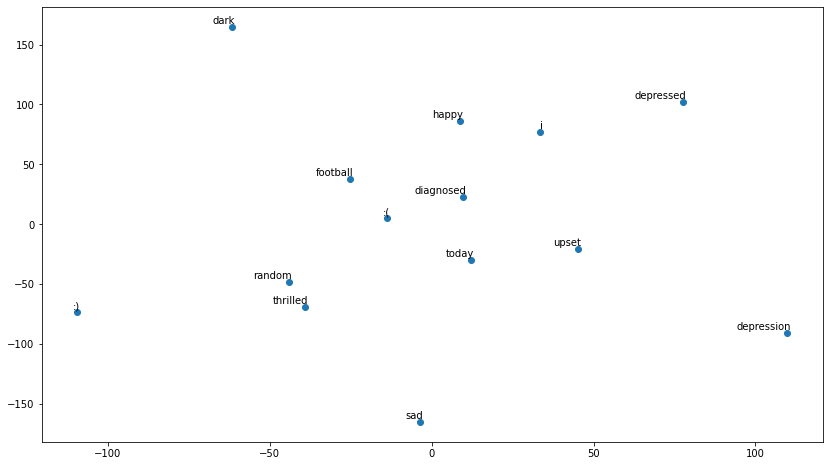

In [ ]:
import matplotlib.pyplot as plt
tsne = TSNE(perplexity=3, n_components=5, init='pca', n_iter=10000, method='exact')
plot_only = len(search_items)
T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [ids_to_word[i+1] for i in range(plot_only)]
labels = search_items
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), 
                 textcoords='offset points', ha='right',va='bottom')


Testing

In [ ]:
predictions = model.predict(X_test)

In [ ]:
print(predictions)
def custom_round(i, t=None):
  if t == 'list':
    i = i[0]
  if i >=0.5:
    return 1
  else:
    return 0
y_hat = [custom_round(p) for p in predictions]


[[[0.5049039 ]]

 [[0.50697434]]

 [[0.5050979 ]]

 ...

 [[0.50587153]]

 [[0.5054535 ]]

 [[0.5079675 ]]]
{1}


In [ ]:
from sklearn.metrics import classification_report
print(test_labels[0])
print(classification_report(test_labels, y_hat, target_names=['None', 'Depressed']))

0
              precision    recall  f1-score   support

        None       0.00      0.00      0.00      1403
   Depressed       0.07      1.00      0.12       100

    accuracy                           0.07      1503
   macro avg       0.03      0.50      0.06      1503
weighted avg       0.00      0.07      0.01      1503



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Bi/LSTM Model experimentation

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Embedding
from tensorflow.keras.models import Sequential, Model

embedding_size=100
vocab_size=len(final_vocab)+1

s_model= Sequential()
s_model.add(Embedding(vocab_size, embedding_size))
#s_model.add(LSTM(embedding_size, return_sequences=True))
s_model.add(Bidirectional(LSTM(embedding_size)))
s_model.add(Dense(50, activation='relu'))
s_model.add(Dense(30, activation='relu'))
s_model.add(Dense(10, activation='relu'))
s_model.add(Dense(1, activation='sigmoid'))

s_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics =['accuracy'])
s_model.summary()
s_model.fit(X_train, train_labels, epochs=1, verbose=2, validation_split=0.1, batch_size=1000)#, class_weight=weights)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2211900   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 50)                10050     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 2,384,601
Trainable params: 2,384,601
Non-trainable params: 0
____________________________________________

In [ ]:
predictions = s_model.predict(X_test)
def custom_round(i):
  if i >=0.5:
    return 1
  else:
    return 0
y_hat = [custom_round(p) for p in predictions]
print(set(y_hat))
print(max(predictions))

from sklearn.metrics import classification_report
print(test_labels[0])
test_labels = labels(test_label)
print(classification_report(test_labels, y_hat, target_names=['None', 'Depressed']))

{0, 1}
[0.9936063]
0
inside
              precision    recall  f1-score   support

        None       0.69      0.72      0.70     58069
   Depressed       0.70      0.67      0.69     57781

    accuracy                           0.70    115850
   macro avg       0.70      0.70      0.70    115850
weighted avg       0.70      0.70      0.70    115850



## Attention models

In [ ]:
from tensorflow.compat.v1.keras.models import Model
from tensorflow.keras.layers import Input, Attention, Conv1D, Concatenate, Embedding
import tensorflow as tf
weights_new = {0:1, 1:5}
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))


query_input = Input(shape=(None,), dtype='int32')
value_input = Input(shape=(None,), dtype='int32')

token_embeddings = Embedding(vocab_size, embedding_size)#, embeddings_initializer='glorot_uniform')
query_embeddings = token_embeddings(query_input)
value_embeddings = token_embeddings(value_input)

cnn_layer = Conv1D(filters=100, kernel_size=1, padding='same')#og filters=100, kernel_size=4
lstm_layer = Bidirectional(LSTM(embedding_size, return_sequences=True))
query_seq_encoding = cnn_layer(query_embeddings)
value_seq_encoding = cnn_layer(value_embeddings)

qv_attention_seq = Attention()([query_seq_encoding, value_seq_encoding])


query_encoding = GlobalAveragePooling1D()(query_seq_encoding)
query_value_attention = GlobalAveragePooling1D()(qv_attention_seq)

conc = Concatenate()([query_encoding, query_value_attention])

'''dns1 = Dense(50, activation='relu')(conc)
dns2 = Dense(20, activation='relu')(dns1)
dns3 = Dense(10, activation='relu')(dns2)
'''
output = Dense(1, activation='sigmoid', name='out')(conc)

model2 = Model(inputs = [query_input, value_input], outputs=[output])
model2.compile(loss = 'binary_crossentropy', optimizer='adam', metrics =['accuracy'])

model2.summary()
model2.fit([X_train, X_train],train_labels, epochs=1, verbose=1, validation_split=0.1, batch_size=1000)#, class_weight=weights_new)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 100)    2211900     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 100)    10100       embedding_4[0][0]     

In [ ]:
from sklearn.metrics import classification_report

def custom_round(i, threshold=0.5):
  if i >=threshold:
    return 1
  else:
    return 0
predictions=model2.predict([X_test, X_test], batch_size=1000)
y_hat = [custom_round(p) for p in predictions]

print(classification_report(test_labels, y_hat, target_names=['None', 'Depressed']))

              precision    recall  f1-score   support

        None       0.69      0.70      0.70     58069
   Depressed       0.70      0.68      0.69     57781

    accuracy                           0.69    115850
   macro avg       0.69      0.69      0.69    115850
weighted avg       0.69      0.69      0.69    115850



## Self Attention Models

In [ ]:
!pip3 install keras-self-attention
!pip3 show tensorflow
!pip3 show keras
!pip3 install keras-multi-head

  Created wheel for keras-self-attention: filename=keras_self_attention-0.47.0-cp36-none-any.whl size=17289 sha256=ff3f5df9510b7928fe6eea981951943303e94cdb7d0f47e346537aae89dc840e
  Stored in directory: /root/.cache/pip/wheels/70/87/01/76c703d5401b65e323927c1fdc665f3fb143282ff67d71e859
Successfully built keras-self-attention
Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: opt-einsum, gast, numpy, termcolor, astunparse, protobuf, wheel, h5py, tensorboard, wrapt, six, grpcio, scipy, absl-py, google-pasta, tensorflow-estimator, keras-preprocessing
Required-by: fancyimpute
Name: Keras
Version: 2.4.3
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MI

In [ ]:
from keras_self_attention import SeqSelfAttention
from keras_multi_head import MultiHead, MultiHeadAttention
import keras
new_weights = {0:1, 1:5}
vector_size=120
embedding_size=100
vocab_size=len(final_vocab)+1

sa_model = keras.models.Sequential()
sa_model.add(keras.layers.Embedding(vocab_size, embedding_size, input_shape=(vector_size,), mask_zero=False))
sa_model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, 
                                                         return_sequences=True)))
#sa_model.add(MultiHead(SeqSelfAttention(attention_activation='sigmoid')))
sa_model.add(SeqSelfAttention(attention_activation='sigmoid'))
#sa_model.add(keras.layers.Flatten())
sa_model.add(keras.layers.Dense(1, activation='sigmoid'))



'''input_key = keras.layers.Input(name='KeyInput', shape=(120,))
input_value=keras.layers.Input(name='ValueInput', shape=(120,))
#emb_query = keras.layers.Embedding(vocab_size, embedding_size, input_shape=(120,), name='QueryEmb')(input_query)
emb_key=keras.layers.Embedding(vocab_size, embedding_size, input_shape=(120,), name='KeyEmb')(input_key)
emb_value=keras.layers.Embedding(vocab_size, embedding_size, input_shape=(120,), name='ValueEmb')(input_value)
enc_block = encoder1_block([emb_query, emb_key, emb_value])
dns1=keras.layers.Dense(10, activation='relu')(enc_block)
out=keras.layers.Dense(1, activation='sigmoid')(dns1)

'''


'''
input_query= keras.layers.Input(name='QueryInput', shape=(vector_size,))
input_key = keras.layers.Input(name='KeyInput', shape=(vector_size,))
input_value=keras.layers.Input(name='ValueInput', shape=(vector_size,))
emb_query = keras.layers.Embedding(vocab_size, embedding_size, input_shape=(vector_size,), name='QueryEmb')(input_query)
emb_key=keras.layers.Embedding(vocab_size, embedding_size, input_shape=(vector_size,), name='KeyEmb')(input_key)
emb_value=keras.layers.Embedding(vocab_size, embedding_size, input_shape=(vector_size,), name='ValueEmb')(input_value)
bilstm=keras.layers.Bidirectional(keras.layers.LSTM(embedding_size, return_sequences=True))

cnn_layer1= keras.layers.Conv1D(filters=100, kernel_size=1, padding='same')
cnn_layer2=keras.layers.Conv1D(filters=100, kernel_size=2, padding='same')
cnn_layer3=keras.layers.Conv1D(filters=100, kernel_size=3, padding='same')
batch_norm = keras.layers.BatchNormalization()
dropout= keras.layers.Dropout(rate=0.5)
att = MultiHeadAttention(head_num=2, name='MultiHeadAttention')([emb_query, emb_key, emb_value])
#bi = bilstm([att])
drop = dropout(att)
lin=keras.layers.Dense(64, activation='relu')(drop)
non_lin_att = SeqSelfAttention(attention_activation='sigmoid')(lin)

#add dropouts
#break linearity
pool=keras.layers.GlobalMaxPooling1D()(non_lin_att)

#flat=keras.layers.Flatten()(att)
dns1 = keras.layers.Dense(10, activation='relu', name='FC')(pool)
out=keras.layers.Dense(1, activation='sigmoid', name='Out')(dns1)
sa_model=keras.models.Model(inputs=[input_query, input_key, input_value], outputs=[out])

#sa_model=keras.models.Model(inputs=[input_key,input_value], outputs=[out])
'''
#adam = keras.optimizers.Adam(learning_rate=1)
sa_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])#adam opt
sa_model.summary()

sa_model.fit(X_train,train_labels, epochs=1, verbose=1, validation_split=0.2, batch_size=1000, class_weight=new_weights)
#sa_model.save('/content/drive/My Drive/UK/MHA_model.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 100)          6454800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120, 256)          234496    
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           257       
Total params: 6,706,002
Trainable params: 6,706,002
Non-trainable params: 0
_________________________________________________________________
2310/2310 [==============================] - 543s 235ms/step - loss: 0.7053 - accuracy: 0.8927 - val_loss: 0.3429 - val_accuracy: 0.9013


In [ ]:
import numpy as np
keys , vals = np.unique(test_labels, return_counts=True)
new_weights = {k:sum(vals)/v for k, v in zip(keys, vals)}
print(new_weights)
print(np.unique(test_labels))


{0: 1.0876310253581913, 1: 12.411483500421303}
[0 1]


Definition of post-training tasks: get fine grained accuracies (get_accuracies: true positives, false positives, true negatives, true positives); annotate experiment/training dataset.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
def custom_round(i, threshold=0.5):

  if i >=threshold:
    return 1
  else:
    return 0
def certainty(i, threshold=0.5):
  if threshold>0.5:
    return abs(i-threshold)/(1-threshold)
  else:
    return abs(i-threshold)/threshold

def get_accuracies():
  predictions=sa_model.predict(X_test, batch_size=100)
  y_hat = [custom_round(p[0]) for p in predictions]
  tn, fp, fn, tp = confusion_matrix(test_labels, y_hat).ravel()
  print(tn, fp, fn, tp)
  print(classification_report(test_labels, y_hat, target_names=['None', 'Depressed']))

def exp_annot():
  predictions=sa_model.predict(X_exp, batch_size=100)
  print(type(predictions))
  print(predictions)
  print(np.shape(predictions))
  y_hat = [custom_round(p.mean()) for p in predictions]
  print(set(y_hat))
  #uncertainty = [certainty(i)[0] for i in predictions]
  #exp['Sig_out'] = pd.Series([p for p in predictions], index=exp.index)
  exp['predictions']= pd.Series(y_hat, index=exp.index)
  #exp['certainty'] = pd.Series(uncertainty, index=exp.index)

def test_annot():
  predictions=sa_model.predict(X_test, batch_size=1000)
  y_hat = [custom_round(p) for p in predictions]
  print(set(y_hat))
  uncertainty = [certainty(i)[0] for i in predictions]
  test['Sig_out'] = pd.Series([p for p in predictions], index=test.index)
  test['predictions']= pd.Series(y_hat, index=test.index)
  test['certainty'] = pd.Series(uncertainty, index=test.index)

get_accuracies()
#exp_annot()
#test_annot()




55770 2299 41080 16701
              precision    recall  f1-score   support

        None       0.58      0.96      0.72     58069
   Depressed       0.88      0.29      0.44     57781

    accuracy                           0.63    115850
   macro avg       0.73      0.62      0.58    115850
weighted avg       0.73      0.63      0.58    115850



In [ ]:
000#exp
#test.to_csv('/content/drive/My Drive/Germany/development/test_indiv_results.csv')
#exp.to_csv('/content/drive/My Drive/Germany/experiment/indiv_exp_results.csv')

In [ ]:
from sklearn.metrics import classification_report

#predictions = model2.predict([X_test, X_test])
def custom_round(i, threshold=0.5):
  if i >=threshold:
    return 1
  else:
    return 0

def certainty(i, threshold=0.5):
  if threshold>0.5:
    return abs(i-threshold)/(1-threshold)
  else:
    return abs(i-threshold)/threshold


def certainty_in_pred(gt, pred, threshold=0.5):
  tp_s, tn_s, fp_s, fn_s=0,0,0,0
  tp_c, tn_c, fp_c, fn_c=0,0,0,0
  tp_a, tn_a, fp_a, fn_a=[], [], [], []
  res = []
  for p, l in zip(pred, gt):
    yhat = custom_round(p, threshold=threshold)
    if l==0 and yhat==0:
      tn_c+=1
      tn_s+=p
      tn_a.append(p)
      res.append('TN')
    elif l==0 and yhat==1:
      fp_c+=1
      fp_s+=p
      fp_a.append(p)
      res.append('FP')
    elif l==1 and yhat==1:
      tp_c+=1
      tp_s+=p
      tp_a.append(p)
      res.append('TP')
    elif l==1 and yhat==0:
      fn_c+=1
      fn_s+=p
      fn_a.append(p)
      res.append('FN')
    else:
      print('prob')
  return {'TN':tn_s/tn_c, 'FN': fn_s/fn_c, 'TP': tp_s/tp_c, 'FP': fp_s/fp_c}, {'TN':np.std(tn_a), 'FN':np.std(fn_a), 'TP':np.std(tp_a), 'FP':np.std(fp_a)}, res
  
'''t=0.65
#predictions=model2.predict([X_exp, X_exp])
#predictions=model2.predict([X_test, X_test], batch_size=32)
predictions=sa_model.predict([X_test, X_test, X_test], batch_size=1000)
y_hat = [custom_round(p, threshold=t) for p in predictions]
uncertainty = [certainty(i, threshold=t)[0] for i in predictions]
print(uncertainty[:5])
certainty_summary, certainty_std, res=certainty_in_pred(test_labels, predictions, threshold=t)
print(set(y_hat))
print('Certainry Summary')
print(certainty_summary)
print('Certainty Std Dev')
print(certainty_std)
predictions=[p for p in predictions]
#train['prediction'] = pd.Series(y_hat, index=train.index) #indicies of below are train
#train['Sig_out'] = pd.Series(predictions, index=train.index)
#train['res'] = pd.Series(res, index=train.index)
#train.to_csv('/content/drive/My Drive/UK/train_results_pred_sigout_res.csv')
#exp['prediction'] = pd.Series(y_hat, index=exp.index)
#exp['certainty']=pd.Series(uncertainty, index=exp.index)
#exp.to_csv('/content/drive/My Drive/UK/exp_indiv_pred_w_cert.csv')

print(classification_report(test_labels, y_hat, target_names=['None', 'Depressed']))'''

predictions=sa_model.predict(X_train, batch_size=1000)
y_hat = [custom_round(p) for p in predictions]
uncertainty = [certainty(i)[0] for i in predictions]
train['Sig_out'] = pd.Series([p for p in predictions], index=train.index)
train['predictions']= pd.Series(y_hat, index=train.index)
train['certainty'] = pd.Series(uncertainty, index=train.index)



In [ ]:
train.to_csv('/content/drive/My Drive/UK/train_for_validation.csv')
test.to_csv('/content/drive/My Drive/UK/test_for_validation.csv')

## Pretrained BERT

In [ ]:
!pip3 install tensorflow_hub
!pip3 install tqdm
!pip3 install --upgrade 'tensorflow==1.15.0'

Requirement already up-to-date: tensorflow==1.15.0 in /usr/local/lib/python3.6/dist-packages (1.15.0)


In [ ]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
import numpy as np
from tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K

sess = tf.Session()


bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 120

class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  
  """


class InputExample(object):

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():

    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=120):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=120):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

# Task 1
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()
# Convert data to InputExample format
InputExamplesTrain=convert_text_to_examples(recons_sent,train_labels)
InputExamplesTest=convert_text_to_examples(recons_sent_test,test_labels)
# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels) = convert_examples_to_features(tokenizer, InputExamplesTrain)
(test_input_ids, test_input_masks, test_segment_ids, test_labels) = convert_examples_to_features(tokenizer, InputExamplesTest)
# End of Task 1

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [ ]:
# Task 2
# Build model

print(np.unique(train_labels))

input_ids = tf.keras.layers.Input((max_seq_length,), dtype='float32', name='IDInput')
input_masks = tf.keras.layers.Input((max_seq_length,), dtype='float32', name='MASKSInput')
input_segment_ids = tf.keras.layers.Input((max_seq_length,), dtype='float32', name='SEGMENTIDInput')
major_input = [input_ids, input_masks, input_segment_ids]
bert = BertLayer(n_fine_tune_layers=1)(major_input)
output = tf.keras.layers.Dense(1, activation='sigmoid')(bert)

model = tf.keras.models.Model(inputs=[major_input], outputs = [output])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# End of Task 2


def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

[0 1]
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
weights = {0:1, 1:11.46}

In [ ]:
weights={0:1, 1:5}
# Instantiate variables
initialize_vars(sess)
print(np.unique(train_labels))
print(type(train_input_ids), type(train_input_masks), type(train_segment_ids), type(train_labels))

model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    epochs=1,
    batch_size=100)
    #, class_weight=weights

#validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),

[0 1]
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Train on 463398 samples
463398/463398 [==============================] - 2220s 5ms/sample - loss: 0.6747 - acc: 0.5651


In [ ]:
from sklearn.metrics import classification_report

def custom_round(i):
  if i >=0.5:
    return 1
  else:
    return 0

predictions=model.predict([test_input_ids, test_input_masks, test_segment_ids], batch_size=100)
y_hat = [custom_round(p) for p in predictions]

print(classification_report(test_labels, y_hat, target_names=['None', 'Depressed']))

              precision    recall  f1-score   support

        None       0.65      0.50      0.57     58069
   Depressed       0.59      0.73      0.65     57781

    accuracy                           0.61    115850
   macro avg       0.62      0.61      0.61    115850
weighted avg       0.62      0.61      0.61    115850

